In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model , Sequential , save_model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os 
import cv2
import imageio
from PIL import Image
import PIL

Data loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!unzip /content/drive/MyDrive/times+verdana.zip
!unzip /content/drive/MyDrive/step1_png.zip

def load(path):
    X = []
    Y = []
    labels = {
        0: 'CAM02',
        1: 'CAM01'}
    label = labels[0]
    for file in os.listdir(os.path.join(path, label)):
        image = cv2.imread(
            os.path.join(path, label, file),
            cv2.IMREAD_GRAYSCALE)
        
        image = image[218:1242,156:2204]
        # image = image[300:1324,300:1324] # per dim 1024
        # image = image[474:986,924:1436] per dim 512

        image = image.astype('float32')/255.

        X.append(image)

    label = labels[1]
    for file in os.listdir(os.path.join(path, label)):
        image = cv2.imread(
            os.path.join(path, label, file),
            cv2.IMREAD_GRAYSCALE)
        
        image = image[218:1242,156:2204]
        #image = image[300:1324,300:1324]
        
        image = image.astype('float32')/255.

        Y.append(image)

    return np.array(X), np.array(Y) #.astype('float32')

# path

path = '/content/step1_png' 
#path = '/content/half_times_step5'
#path = '/content/'

# dati caricati
X, Y = load(path)    

Archive:  /content/drive/MyDrive/step1_png.zip
   creating: step1_png/CAM01/
  inflating: step1_png/CAM01/focusStep_1_timesR_size_30_sample_0001.png  
  inflating: step1_png/CAM01/focusStep_1_timesR_size_30_sample_0002.png  
  inflating: step1_png/CAM01/focusStep_1_timesR_size_30_sample_0003.png  
  inflating: step1_png/CAM01/focusStep_1_timesR_size_30_sample_0004.png  
  inflating: step1_png/CAM01/focusStep_1_timesR_size_30_sample_0005.png  
  inflating: step1_png/CAM01/focusStep_1_timesR_size_30_sample_0006.png  
  inflating: step1_png/CAM01/focusStep_1_timesR_size_30_sample_0007.png  
  inflating: step1_png/CAM01/focusStep_1_timesR_size_30_sample_0008.png  
  inflating: step1_png/CAM01/focusStep_1_timesR_size_30_sample_0009.png  
  inflating: step1_png/CAM01/focusStep_1_timesR_size_30_sample_0010.png  
  inflating: step1_png/CAM01/focusStep_1_timesR_size_30_sample_0011.png  
  inflating: step1_png/CAM01/focusStep_1_timesR_size_30_sample_0012.png  
  inflating: step1_png/CAM01/focusS

In [ ]:
X.shape , Y.shape

((200, 1024, 2048), (200, 1024, 2048))

In [14]:
a, test_corrupt, b, test_images = train_test_split(X,Y,test_size=6/200,shuffle=False, random_state=23)
a, val_corrupt, b, val_images = train_test_split(a,b,test_size=6/194,shuffle=False, random_state=23)
a, train_corrupt, b, train_images = train_test_split(a,b,test_size=30/188,shuffle=False, random_state=23)

In [4]:

# fixing test set
a, test_corrupt, b, test_images = train_test_split(X,Y,test_size=6/200,shuffle=False, random_state=23)
a, val_corrupt, b, val_images = train_test_split(a,b,test_size=6/194,shuffle=False, random_state=23)
a, train_corrupt, b, train_images = train_test_split(a,b,test_size=80/188,shuffle=False, random_state=23)

In [15]:
train_images.shape, train_corrupt.shape, val_images.shape, val_corrupt.shape, test_corrupt.shape, test_images.shape, a.shape, b.shape

((30, 1024, 2048),
 (30, 1024, 2048),
 (6, 1024, 2048),
 (6, 1024, 2048),
 (6, 1024, 2048),
 (6, 1024, 2048),
 (158, 1024, 2048),
 (158, 1024, 2048))

In [17]:
train_corrupt = tf.reshape(train_corrupt, [-1,1024, 2048,1])
val_corrupt = tf.reshape(val_corrupt, [-1,1024, 2048,1])
train_images = tf.reshape(train_images, [-1,1024, 2048,1])
val_images = tf.reshape(val_images, [-1,1024, 2048,1])
test_corrupt = tf.reshape(test_corrupt, [-1,1024, 2048,1])
test_images = tf.reshape(test_images, [-1,1024, 2048,1])

Network definition and training

In [ ]:

from keras import layers
from tensorflow.keras.utils import plot_model

SRCNN=tf.keras.models.Sequential([tf.keras.layers.Conv2D(64,9,padding='same',activation='relu'),
tf.keras.layers.Conv2D(64,1,padding='same',activation='relu'),
tf.keras.layers.Conv2D(3,5,padding='same',activation='relu')])

input_img=Input(shape=(1024,2048,1))
l1=tf.keras.layers.Conv2D(64,9,padding='same',activation='relu') (input_img)
l2=tf.keras.layers.Conv2D(32,1,padding='same',activation='relu') (l1)
l3=tf.keras.layers.Conv2D(3,5,padding='same',activation='relu') (l2)

SRCNN=Model(input_img,l3)

#def pixel_mse_loss(x,y):
#   return tf.reduce_mean( (x - y) ** 2 )


In [ ]:
SRCNN.compile(optimizer='adam',loss='mean_squared_error',metrics='mae')
SRCNN.summary()
plot_model(SRCNN, to_file ='super_res.png',show_shapes=True)
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights=True) #serve per early stopping

history = SRCNN.fit(
    train_corrupt,
    train_images,
    epochs = 20,
    callbacks = [callback],
    batch_size =1,
    validation_data =(val_corrupt,val_images)
)

In [ ]:
results = SRCNN.evaluate(test_corrupt,test_images)

1/1 [==============================] - 0s 278ms/step - loss: 0.0036 - mae: 0.0315


In [ ]:
predictions = SRCNN.predict(test_corrupt)

In [ ]:
run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
  #    RunOptions(report_tensor_allocations_upon_oom = True)


printing and comparing the images: predicted/blurred/original/differences:

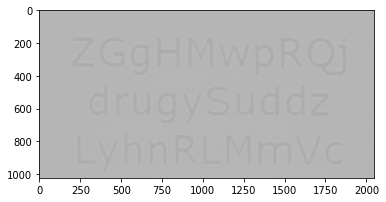

In [ ]:
pred = np.asarray(predictions)
uno = pred[2,:,:,0]
a=plt.imshow(uno,cmap='gray', vmin=0, vmax=1.)

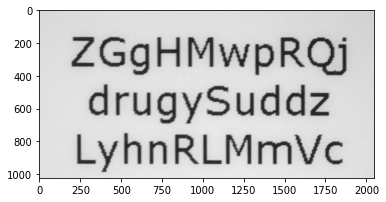

In [ ]:
uno_stripe = test_corrupt[2,:,:,0]
plt.imshow(uno_stripe,cmap='gray', vmin=0, vmax=1.)

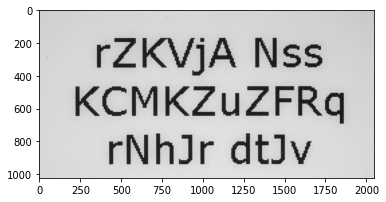

In [18]:
uno_label = test_images[2,:,:,0]
plt.imshow(uno_label,cmap='gray', vmin=0, vmax=1.)

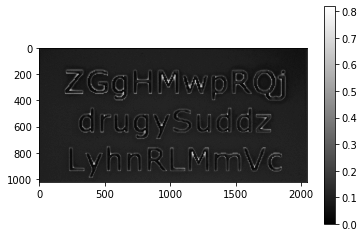

In [ ]:
diff=np.abs(uno_label-uno)
plt.imshow(diff,cmap='gray', vmin=0, vmax=np.max(diff))
plt.colorbar()

In [ ]:
np.max(diff)

0.7071848

summary of the model

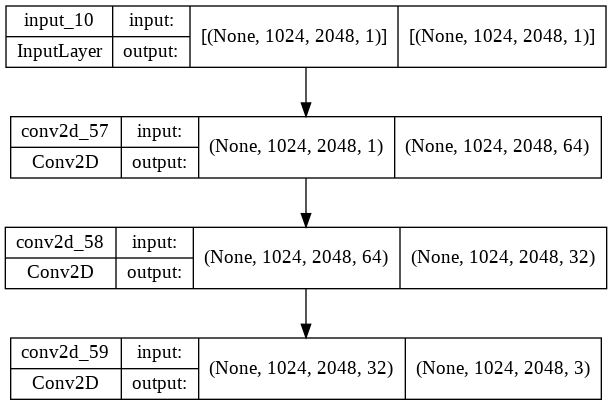

In [ ]:
tf.keras.utils.plot_model(
    SRCNN, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

Stampiamo loss e performance sul train e validation:

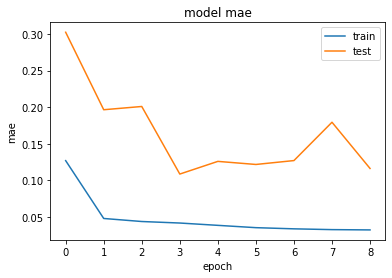

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

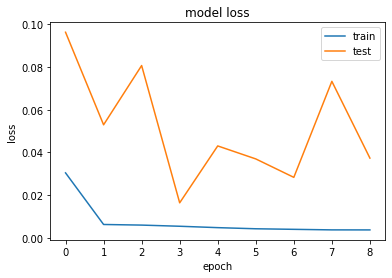

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()